# Multiclass Adam (and SGD) on a general problem class

#### Notes
 
 - I super recommend using a GPU to run this, otherwise it's slow.
 - Code currently can't handle a non-diagonal data covariance for Adam. The "gradient noise term" isn't calculated correctly (It gets much more expensive). TODO
 - If Adam looks bad increase the "history_length" and "num_samples" values in the "compute_phi..." and "compute_cov.." functions. These control and approximation quality

100%|██████████| 3000/3000 [00:43<00:00, 69.65it/s]


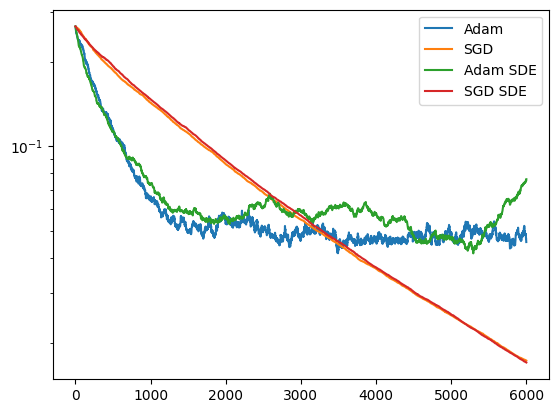

In [2]:
from optimizers import Adam, SGD
from sdes import AdamSDE, SgdSDE
from odes import AdamODE, SgdODE

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy
# Setup the problem and parameters
problem_type = 'linreg' # from  'logreg' or 'linreg'

d = 400 # dimension
m = 3
beta1 = 0 
beta2 = 0.5
T = 15 # time to run SDE for

lr = 1.2 # SDE learning rate
lrk = lr / d # Optimzer learning rate

# lr = lambda x: jnp.cos(2 * x / T) # SDE learning rate
# lrk = lambda x: jnp.cos(2 * x / T / d) / d # Optimizer learning rate

# cov = jnp.linspace(0.1, 1, d) # initialize with diagonal covariance
cov = jnp.array([j**(-0.5) for j in range(1, d+1)])
# cov = jnp.ones(d)
U = scipy.stats.ortho_group.rvs(d)
cov = U @ jnp.diag(cov) @ U.T

# params0 = jnp.linspace(2,0.1,d)
# optimal_params = jnp.linspace(0.1,2,d)

key = jax.random.PRNGKey(np.random.randint(0, 10000))
key_init, key_opt, key = jax.random.split(key, 3)

params0 = jax.random.normal(key_init, (d,m))
optimal_params = jax.random.normal(key_opt, (d,m))

params0 /= norm(params0, axis = 0)
optimal_params /= norm(optimal_params, axis = 0)


# Run the optimizers
adam = Adam(problem_type)
sgd = SGD(problem_type)

_, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
_, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = 0.00)

# Run the SDE equivalents
sgd_sde = SgdSDE(problem_type)
adam_sde = AdamSDE(problem_type)

_, sgd_sde_risks, times_s = sgd_sde.run(params0, optimal_params, cov, T, lr)
params, adam_sde_risks, times_s = adam_sde.run(params0, optimal_params, cov, T, lr, beta1 = beta1, beta2 = beta2)

# Run the ODE equivalents
adam_ode = AdamODE(problem_type)
sgd_ode = SgdODE(problem_type)

# sgd_risk, time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01)
# adam_risk, time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01, beta1 = beta1, beta2 = beta2, eps = 0.001)

plt.yscale('log')
# plt.xscale('log')
plt.plot(adam_risks, label = 'Adam')
plt.plot(sgd_risks, label = 'SGD')

plt.plot(times_s * d, adam_sde_risks, label = 'Adam SDE')
plt.plot(times_s * d, sgd_sde_risks, label = 'SGD SDE')

# plt.plot(time * d, adam_risk, label = 'Adam ODE')
# plt.plot(time * d, sgd_risk, label = 'SGD ODE')

plt.legend()
plt.show()

## Plots showing concentration

100%|██████████| 500/500 [00:31<00:00, 15.81it/s] 


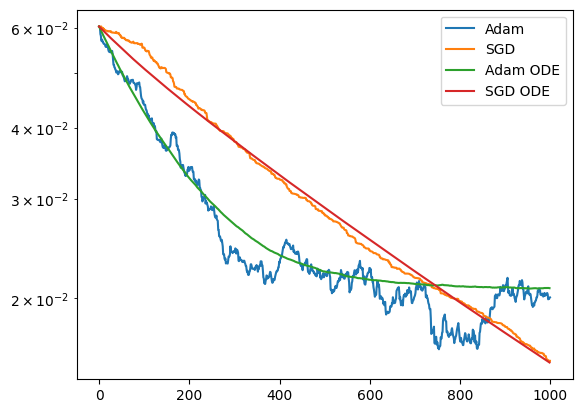

In [ ]:
from optimizers import Adam, SGD
from sdes import AdamSDE, SgdSDE
from odes import AdamODE, SgdODE

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt

problem_type = 'linreg' # from  'logreg' or 'linreg'

d = 200 # dimension
m = 1
beta1 = 0 
beta2 = 0.5
T = 5 # time to run SDE for

lr = 1.2 # SDE learning rate
lrk = lr / d # Optimzer learning rate

cov = jnp.array([j**(-0.5) for j in range(1, d+1)])

# Generate problem with fixed init across dimensions
key = jax.random.PRNGKey(0)
key_opt, key_diff = jax.random.split(key)

optimal_params = jax.random.normal(key_opt, (d, m))
optimal_params /= norm(optimal_params, axis=0, keepdims=True)

# Step 2: Generate differences
diffs = jax.random.normal(key_diff, (d, m))
diffs -= jnp.sum(diffs * optimal_params, axis=0, keepdims=True) * optimal_params
diffs *= 1 / norm(diffs, axis=0, keepdims=True)

# Step 3: Define params0
params0 = optimal_params + diffs

# Run the optimizers
adam = Adam(problem_type)
sgd = SGD(problem_type)

_, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
_, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = 0.00)


# Run the ODE equivalents
adam_ode = AdamODE(problem_type)
sgd_ode = SgdODE(problem_type)

sgd_risk, time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01)
adam_risk, time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01, beta1 = beta1, beta2 = beta2, eps = 0.001)

plt.yscale('log')

plt.plot(adam_risks, label = 'Adam')
plt.plot(sgd_risks, label = 'SGD')


plt.plot(time * d, adam_risk, label = 'Adam ODE')
plt.plot(time * d, sgd_risk, label = 'SGD ODE')

plt.legend()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:37<00:00, 13.39it/s] 


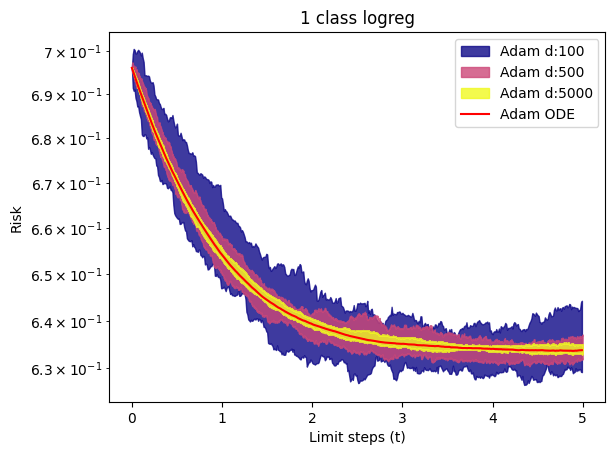

In [14]:
from optimizers import Adam, SGD
from odes import AdamODE, SgdODE

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
from utils import compute_ci


# Settings
problem_type = 'logreg'
m = 1
beta1 = 0 
beta2 = 0.5
T = 5
lr = 1.2
n_runs = 20  # number of trials

ds = [100, 500, 5000]
cmap = plt.get_cmap('plasma')
colors = [cmap(val) for val in np.linspace(0, 1, len(ds))]

for d, color in zip(ds, colors):
    lrk = lr / d
    cov = jnp.ones(d)
    
    # Generate fixed problem for each dimension
    key = jax.random.PRNGKey(np.random.randint(1000))
    key_opt, key_diff = jax.random.split(key)
    optimal_params = jax.random.normal(key_opt, (d, m))
    optimal_params /= norm(optimal_params, axis=0, keepdims=True)

    diffs = jax.random.normal(key_diff, (d, m))
    diffs -= jnp.sum(diffs * optimal_params, axis=0, keepdims=True) * optimal_params
    diffs *= 1 / norm(diffs, axis=0, keepdims=True)

    params0 = optimal_params + diffs

    # Run multiple times
    adam_risks_all = []
    sgd_risks_all = []

    for i in range(n_runs):
        # Initialize optimizers (they get a new RNG key each time)
        adam = Adam(problem_type)
        sgd = SGD(problem_type)

        # _, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
        _, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1=beta1, beta2=beta2, eps=0.00)
        sgd_risks_all.append(sgd_risks)
        adam_risks_all.append(adam_risks)

    # Convert to arrays
    adam_risks_all = jnp.stack(jnp.array(adam_risks_all))
    # sgd_risks_all = jnp.stack(jnp.array(sgd_risks_all))

    adam_mean, adam_lower, adam_upper = compute_ci(adam_risks_all, 0.2)
    # sgd_mean, sgd_lower, sgd_upper = compute_ci(sgd_risks_all, 0.2)

    
    # Plot
    plt.yscale('log')

    steps = jnp.arange(adam_mean.shape[0]) / d
    plt.fill_between(steps, adam_lower, adam_upper, alpha=0.8, color=color, label = f'Adam d:{d}')
    # plt.fill_between(steps, sgd_lower, sgd_upper, alpha=0.3, color=color,  label = f'SGD d:{d}')

# # Run the ODE equivalents
adam_ode = AdamODE(problem_type)
# sgd_ode = SgdODE(problem_type)

# sgd_risk, time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01)
adam_risk, time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01, beta1 = beta1, beta2 = beta2, eps = 0.001)

plt.plot(time, adam_risk, label = 'Adam ODE', color = 'red')
# plt.plot(time, sgd_risk, label = 'SGD ODE')

plt.xlabel('Limit steps (t)')
plt.ylabel('Risk')
plt.legend()
plt.title(f'{m} class {problem_type}')
plt.savefig(f'adam_concentration_m{m}_{problem_type}.pdf', format = 'pdf')
plt.show()